In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from bs4 import BeautifulSoup

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve

from sklearn.inspection import permutation_importance

In [ ]:
df = pd.read_csv('data/IMDB_Dataset.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df['sentiment'].value_counts()

Balanced dataset

In [ ]:
# Check for null values
df.isna().sum()

In [ ]:
df.loc[0][0]

In [ ]:
df.loc[1][0]

In [ ]:
review = df.loc[0][0]

In [ ]:
# Strip html text
soup = BeautifulSoup(review, "lxml")
data = soup.get_text()
data

In [ ]:
# Lower case all text
data = data.lower()
data

In [ ]:
# Remove punctuation
punctuation = string.punctuation.replace('.', '')
data = data.translate(str.maketrans('', '', punctuation))

In [ ]:
pattern = re.compile(r'\s+')
data = re.sub(pattern, ' ', data.replace('.', ' '))

In [ ]:
data

In [ ]:
# Tokenize
data = word_tokenize(data)

In [ ]:
# Get list of nltk's stopwords
stopwords_list = stopwords.words('english')

In [ ]:
# Remove stop words
data = [word for word in data if word not in stopwords_list]

In [ ]:
data[:5]

In [ ]:
# Initialize a PortStemmer object
stemmer = PorterStemmer()

In [ ]:
# Convert the tokens into their stem
data = [stemmer.stem(token) for token in data]

In [ ]:
data[:5]

In [ ]:
def text_preprocessor(review):
    # Strip html text
    soup = BeautifulSoup(review, "lxml")
    data = soup.get_text()
    # Lower case all text
    data = data.lower()
    # Remove edge cases with multiple periods
    pattern = re.compile(r'\s+')
    data = re.sub(pattern, ' ', data.replace('.', ' '))
    # Remove punctuation and other special characters
    pattern = r'[^a-zA-Z\s]'
    data = re.sub(pattern, '', data)
    # Tokenize
    data = word_tokenize(data)
    # Get list of nltk's stopwords
    stopwords_list = stopwords.words('english')
    # Remove stop words
    data = [word for word in data if word not in stopwords_list]
    # Initialize a PortStemmer object
    stemmer = PorterStemmer()
    # Convert the tokens into their stem
    data = [stemmer.stem(token) for token in data]
    # Convert the list of words back into
    # a string by joining each word with a space
    data = ' '.join(data)
    # Remove double spaces
    data = data.replace('  ', ' ')
    # Remove opening and trailing spaces
    data = data.strip()
    # Return the cleaned text data
    return data

In [ ]:
df.review = df.review.apply(text_preprocessor)

In [ ]:
print(df.review[:3])

Number of words per review

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
length_good_reviews = df[df['sentiment'] == 'positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(length_good_reviews, color='blue')
ax1.set_title('Positive Reviews')
length_bad_reviews = df[df['sentiment'] == 'negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(length_bad_reviews, color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
plt.show()

Mean word length per review

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
pos_word = df[df['sentiment'] == 'positive']['review'].str.split().apply(lambda x: [
    len(i) for i in x])
sns.distplot(pos_word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
ax1.set_title('Positive Reviews')
neg_word = df[df['sentiment'] == 'negative']['review'].str.split().apply(lambda x: [
    len(i) for i in x])
sns.distplot(neg_word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Mean word length per review')

In [ ]:
def get_all_words(text):
    words = []
    for x in text:
        for y in x.split():
            words.append(y.strip())
    return words
all_words = get_all_words(df.review)
all_words[:10]

In [ ]:
from collections import Counter
counter = Counter(all_words)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

https://www.kaggle.com/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc/notebook

In [ ]:
def get_top_text_ngrams(text, num_words, ngram):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:num_words]

Unigram Analysis

In [ ]:
most_common_uni = get_top_text_ngrams(df.review, 20, 1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common Words in All Reviews', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

In [ ]:
most_common_uni_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'], 20, 1)
most_common_uni_pos = dict(most_common_uni_pos)
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_uni_pos.keys())
temp["Count"] = list(most_common_uni_pos.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common Words in Positive Reviews', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

In [ ]:
most_common_uni_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'], 20, 1)
most_common_uni_neg = dict(most_common_uni_neg)
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_uni_neg.keys())
temp["Count"] = list(most_common_uni_neg.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Negative Reviews', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

Bigram Analysis

In [ ]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams All Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
most_common_bi_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'],20,2)
most_common_bi_pos = dict(most_common_bi_pos)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi_pos.keys())
temp["Count"] = list(most_common_bi_pos.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Positive Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
most_common_bi_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'],20,2)
most_common_bi_neg = dict(most_common_bi_neg)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi_neg.keys())
temp["Count"] = list(most_common_bi_neg.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Negative Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

Trigram Analysis

In [ ]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common Trigrams All Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
most_common_tri_pos = get_top_text_ngrams(df.review[df.sentiment=='positive'],20,3)
most_common_tri_pos = dict(most_common_tri_pos)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri_pos.keys())
temp["Count"] = list(most_common_tri_pos.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common Trigrams Positive Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
most_common_tri_neg = get_top_text_ngrams(df.review[df.sentiment=='negative'],20,3)
most_common_tri_neg = dict(most_common_tri_neg)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri_neg.keys())
temp["Count"] = list(most_common_tri_neg.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common Trigrams in Negative Reviews', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
# Encode target column
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['review']], df.sentiment, random_state = 42)

In [ ]:
count = CountVectorizer()
tfidf = TfidfVectorizer()

In [42]:
from sklearn.pipeline import make_pipeline

models = {'lr_count': make_pipeline(count, LogisticRegression(max_iter=1000, random_state=42)),
          'dt_count': make_pipeline(count, DecisionTreeClassifier(random_state=42)),
          'rf_count': make_pipeline(count, RandomForestClassifier(random_state=42)),
          'lr_tfidf': make_pipeline(tfidf, LogisticRegression(max_iter=1000, random_state=42)),
          'dt_tfidf': make_pipeline(tfidf, DecisionTreeClassifier(random_state=42)),
          'rf_tfidf': make_pipeline(tfidf, RandomForestClassifier(random_state=42))}

In [43]:
from sklearn.model_selection import cross_val_score

baseline_scores = {}

for model in models:
    score = cross_val_score(models[model], X_train.iloc[:,0], y_train, scoring='f1')
    baseline_scores[model] = score.mean()
    
baseline_scores

{'lr_count': 0.8756128986644571,
 'dt_count': 0.7171327201737887,
 'rf_count': 0.8513636098212689,
 'lr_tfidf': 0.8899069735668492,
 'dt_tfidf': 0.7103410288997866,
 'rf_tfidf': 0.8462421184225345}

In [44]:
lr_pipeline = models['lr_tfidf']

In [45]:
lr_pipeline.fit(X_train.iloc[:,0], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [46]:
def evaluate(estimator, X_train, X_test, y_train, y_test, roc_auc='proba'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set

    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score

    Function takes in:
    'estimator' a fit sklearn model object
    'X_train' dataframe
    'X_test' dataframe
    'y_train' series
    'y_test' series
    'roc_auc' string that defines ...
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    # output needed for roc_auc_score
    if roc_auc == 'skip':  # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec':  # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba':
        train_out = estimator.predict_proba(
            X_train)[:, 1]  # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception(
            "The value for roc_auc should be 'skip', 'dec' or 'proba'.")

    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Precision: {precision_score(y_train, train_preds)}")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray:  # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Precision: {precision_score(y_test, test_preds)}")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")

    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=',.5g')
    plt.grid(False)
    plt.show()

Train Scores
------------
Accuracy: 0.9281066666666666
Precision: 0.9213346708199145
Recall: 0.9353593825373855
F1 Score: 0.9282940581945849
ROC-AUC: 0.978660586482951
--------------------
Test Scores
-----------
Accuracy: 0.89248
Precision: 0.8861424378186312
Recall: 0.904303957118083
F1 Score: 0.8951310861423221
ROC-AUC: 0.9595893116916947


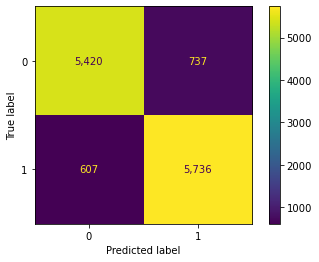

In [47]:
evaluate(lr_pipeline, X_train.iloc[:,0], X_test.iloc[:,0], y_train, y_test, roc_auc='proba')

In [48]:
lr_pipeline.steps[0][-1]

TfidfVectorizer()

In [49]:
# the fit tfidf vectorizer
transformer = lr_pipeline.steps[0][-1]
# the fit logistic regression model
lr_model = lr_pipeline.steps[-1][-1]

In [50]:
X_inspect = transformer.transform(X_test.iloc[:,0]).toarray()

In [ ]:
importance = permutation_importance(lr_model, X_inspect, y_test, random_state=42, scoring='f1')

In [ ]:
# Zip the names of the features 
# with the features permutation importance
importance_weights = list(zip(transformer.get_feature_names(), importance['importances_mean']))

# Sort the weights in descending order
sorted(importance_weights, key=lambda x: x[1], reverse=True)[:100]